## 0.0 Imports

In [59]:
import warnings
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from plotly              import express as px
from sklearn             import cluster as c 
from sklearn             import metrics as m 
from matplotlib          import pyplot  as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

### 0.1 Helper Functions

In [60]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.2 Load Dataset

In [61]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding='ISO-8859-1')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1)

In [62]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.0 Descrição dos Dados

In [63]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [64]:
df1.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [65]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

### 1.2 Data dimension

In [66]:
print( 'Number of rows: {}'.format( df1.shape[0]))
print( 'Number of cols: {}'.format( df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [67]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4 Check NA

In [68]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [69]:
# remove NA
df1 = df1.dropna( subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25


In [70]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.6 Change dtypes

In [71]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [72]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.7 Descriptive Statistics

## 2.0 Feature Engineering

In [73]:
df2 = df1.copy()
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


### 2.1 Feature Creation

In [74]:
# data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

# Gross revenue
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


## 3.0 Filtragem de Variavéis

In [75]:
df3 = df_ref.copy()

## 4.0 EDA (Exploratory Data Analysis)

In [76]:
df4 = df3.copy()

## 5.0 Data Preparation

In [77]:
df5 = df4.copy()

## 6.0 Feature Selection

In [78]:
df6 = df5.copy()

## 7.0 Hyperparameter Fine-Tuning

In [79]:
X = df6.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


In [80]:
clusters = [2, 3, 4, 5, 6, 7]

### 7.1 Within-Cluster Sum of Square (WSS)

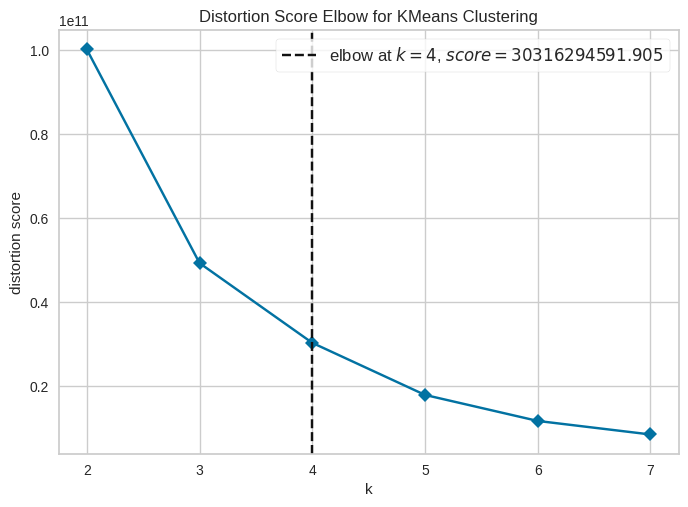

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

### 7.2 Silhouette Score

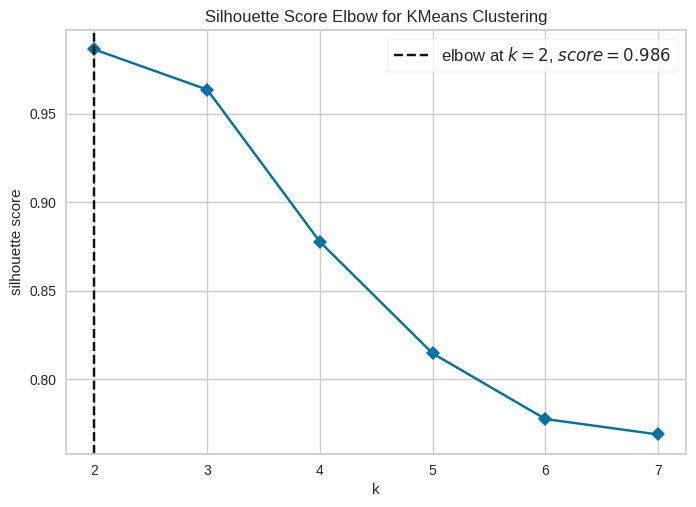

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [82]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

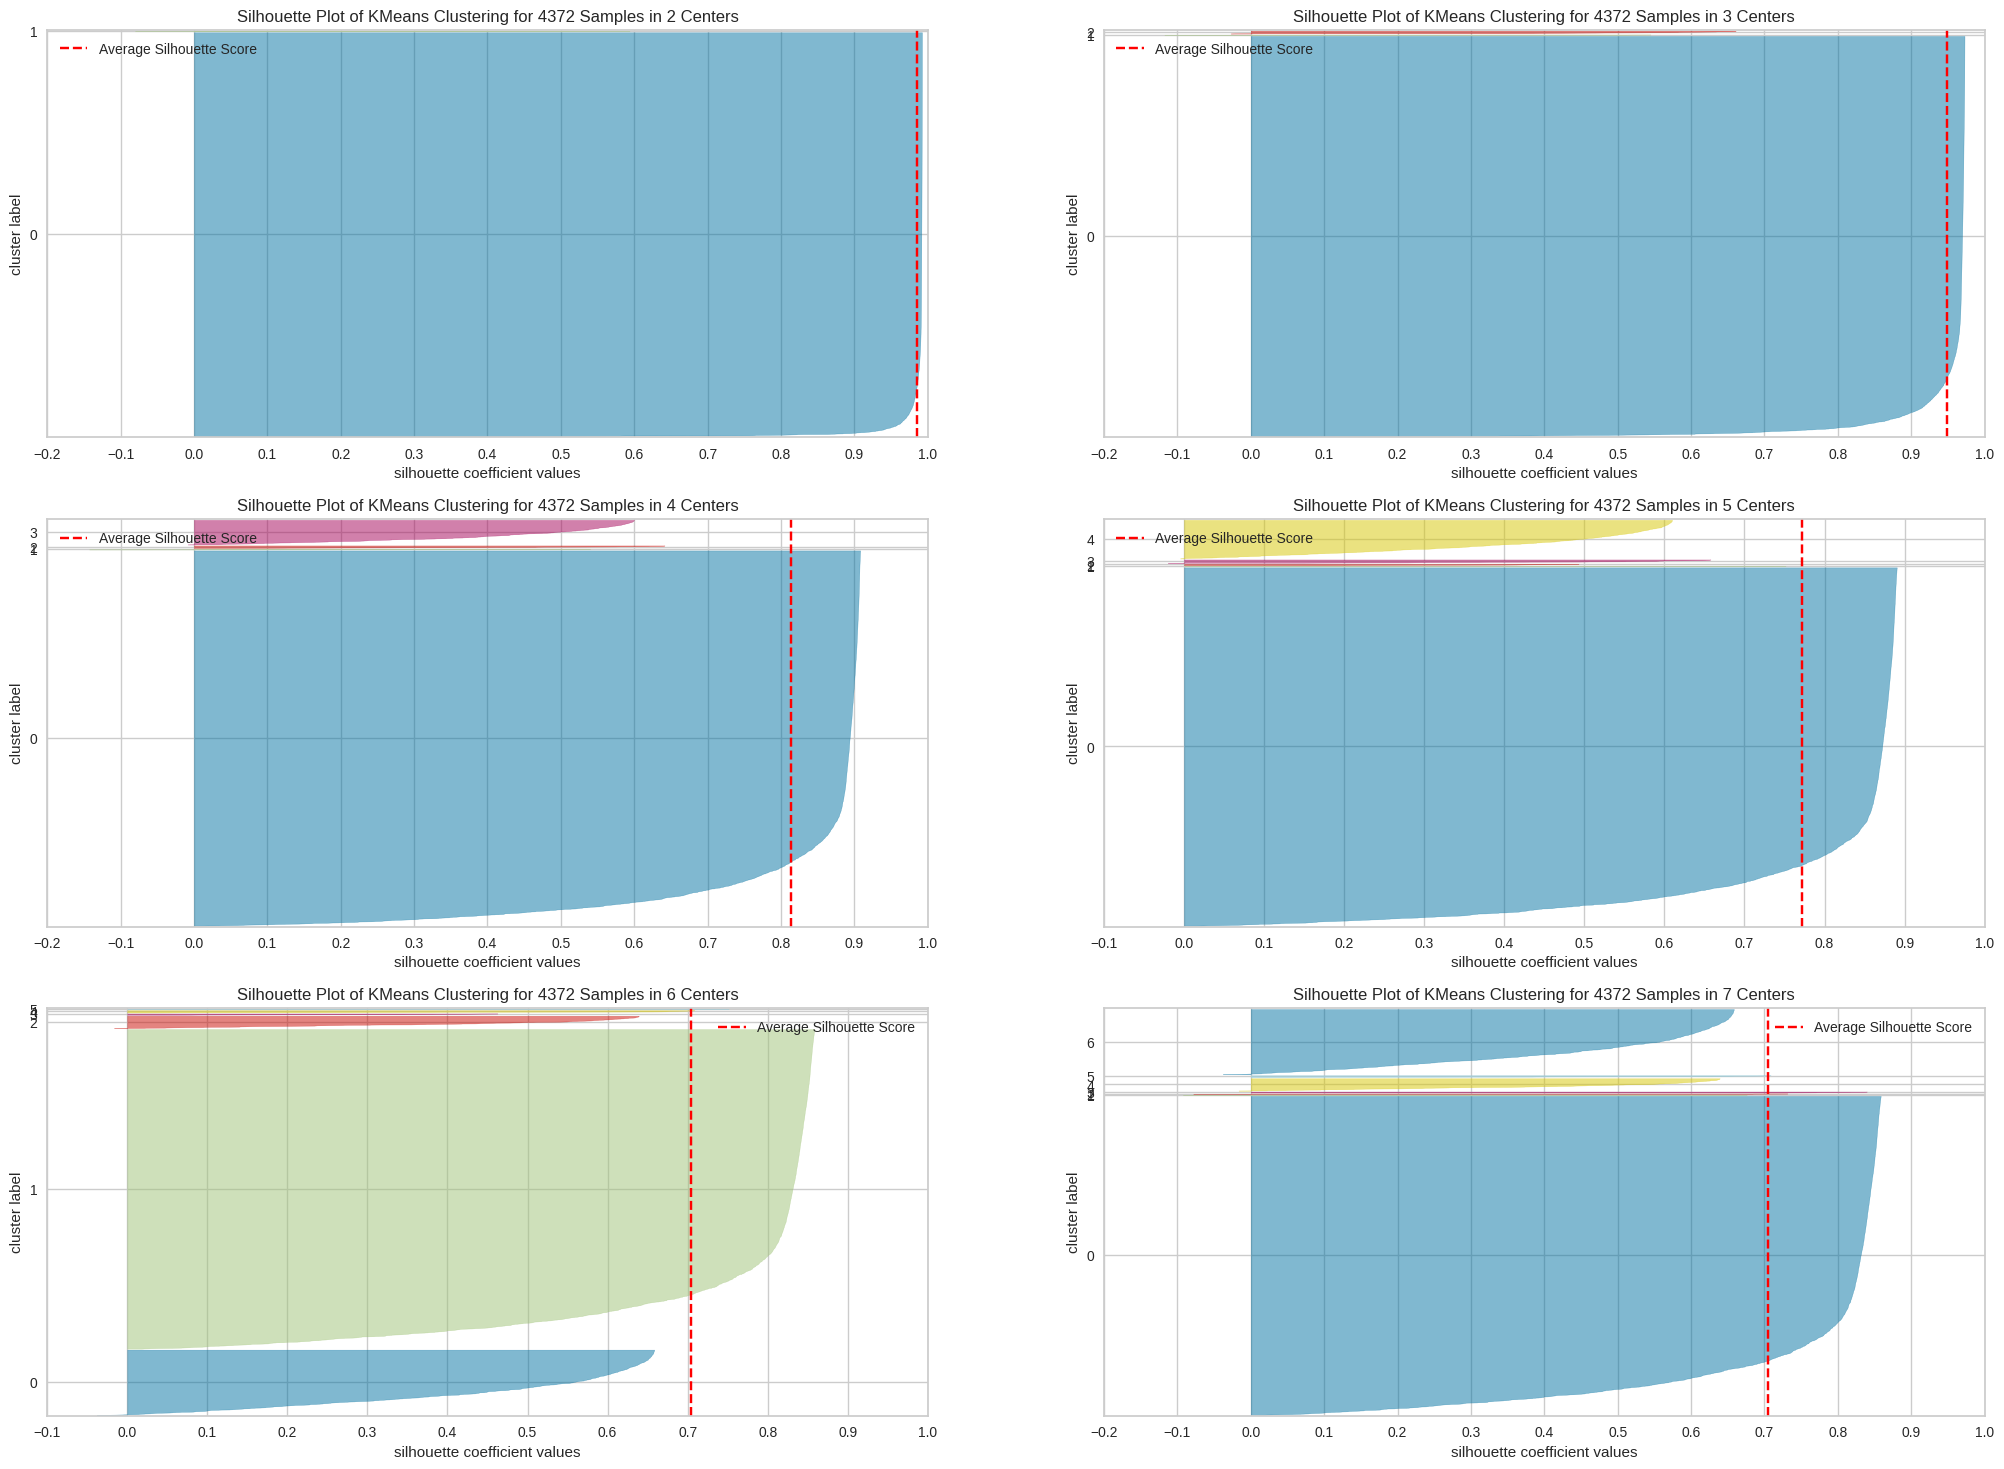

In [83]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k, 2)
    visualizer = SilhouetteVisualizer (km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

## 8.0  Model Training

### 8.1 K-Means

In [84]:
# model definition
k = 4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [85]:
# WSS (Within-cluster Sum of Square)
print( 'WSS value: {}'.format(kmeans.inertia_))

## SS (Silhoutte Score)
print( 'SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40056506734.60243


SS value: 0.8139972028952444


## 9.0 Cluster Analysis

In [86]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


### 9.1 Visualization Inspection

/home/marcelo/anaconda3/envs/env_base/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



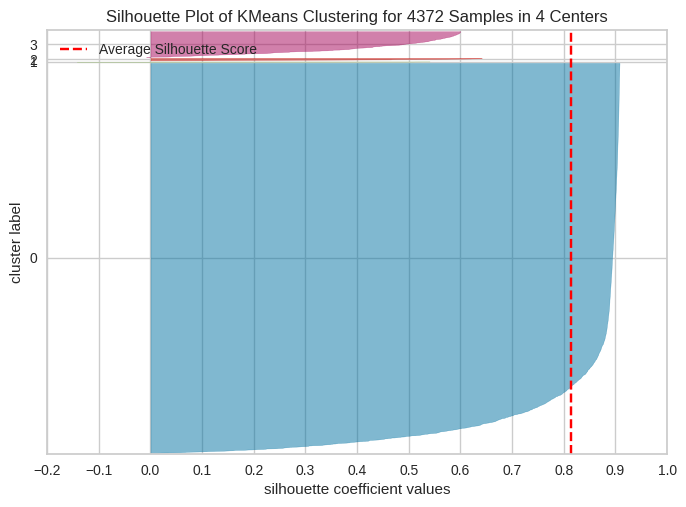

In [87]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.2 2d plot

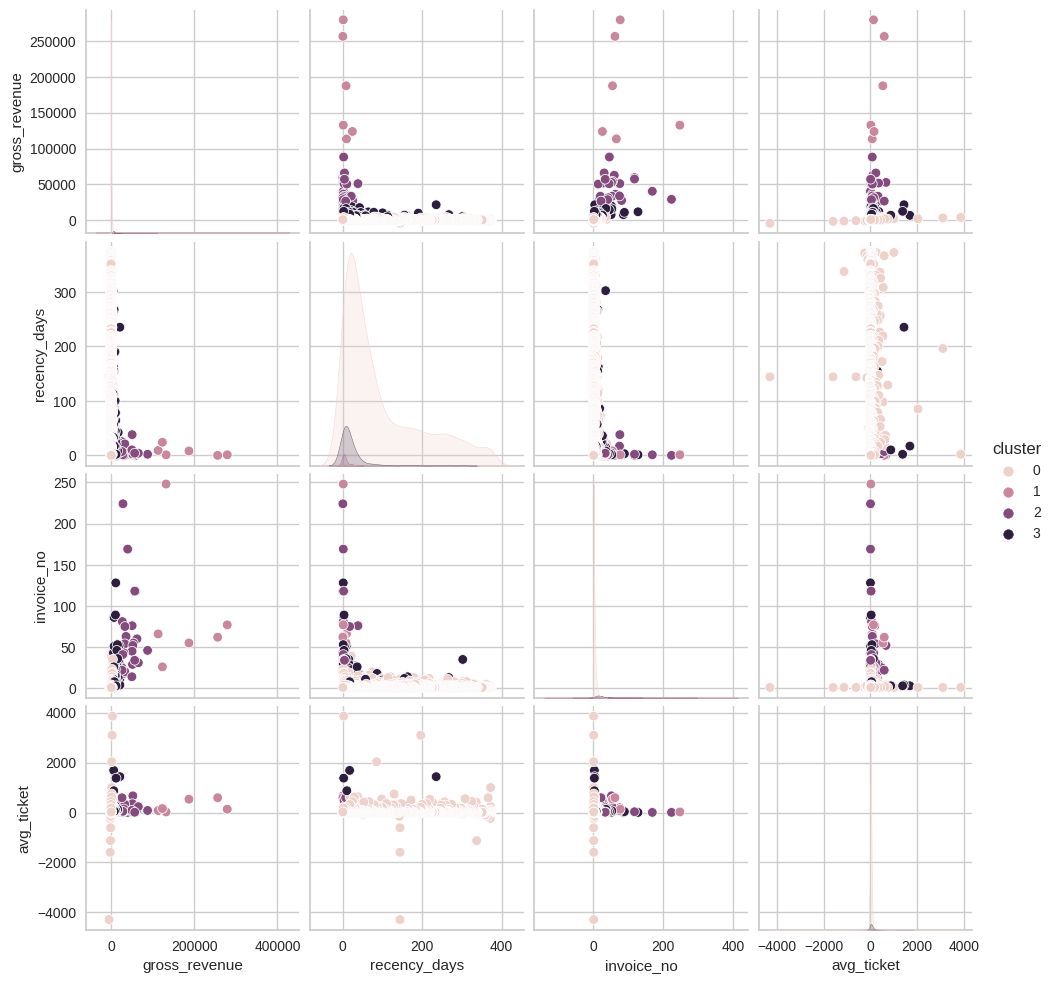

In [88]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

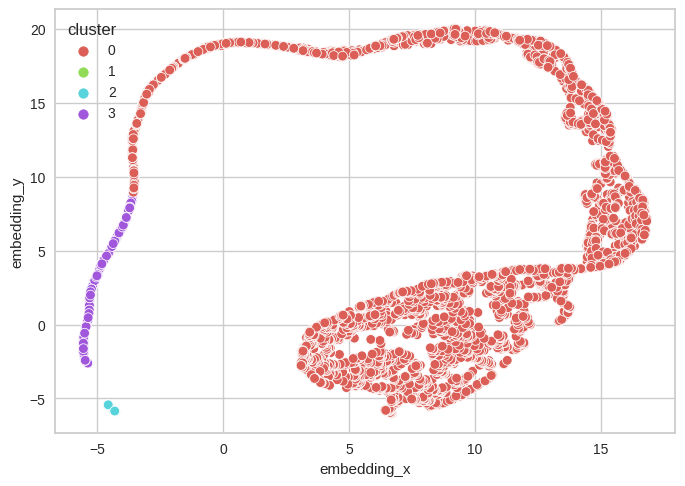

In [89]:
reducer = umap.UMAP( n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

### 9.4 Cluster Profile

In [90]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


In [91]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_invoive_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoive_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
    - Ticket méito: $253,00 dólares
        
### Cluster 02: 
    - Número de customers: 28 (0.64% do customers )
    - Recência em média: 6 dias
    - Compras em média: 57 compras
    - Receita em média: $42.614,00 dólares
    - Ticket médio: $162,00 dólares
        
### Cluster 03: 
    - Número de customers: 267 (6,10% do customers )
    - Recência em média: 20 dias
    - Compras em média: 19 compras
    - Receita em média: $8.089,00 dólares
    - Ticket médio: $62,78 dólares

### Cluster 04: 
    - Número de customers: 4.071 (93,10% do customers )
    - Recência em média: 96 dias
    - Compras em média: 3 compras
    - Receita em média: $946,00 dólares
    - Ticket médio: $25,00 dólares

## 10.0 Deploy to Production